In [1]:
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import os

In [2]:
im_to_cons = pd.read_csv('process_data/all_ims_guide.csv')

In [3]:
im_to_cons.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,nightlight_bin,images,clust_num,images_renamed
0,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.125_35.174999.png,0,-17.125_35.174999_0.png
1,-17.133333,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.133333_35.174999.png,0,-17.133333_35.174999_0.png
2,-17.066666,35.191666,-17.09515,35.217213,0.0,2.039307,1,-17.066666_35.191666.png,0,-17.066666_35.191666_0.png
3,-17.050000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.05_35.199999.png,0,-17.05_35.199999_0.png
4,-17.100000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.1_35.199999.png,0,-17.1_35.199999_0.png


In [4]:
# turn the data into a PyTorch Tensor
data_transforms = {
    'transform': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda')

Run this if you want to see how many the model gets right on the train set. Keep in mind that nightlights is not the main objective but just a means to an end.

In [6]:
# model_ft.eval()   # Set model to evaluate mode

# running_loss = 0.0
# running_corrects = 0
# total = 0

# # Iterate over data.
# for inputs, labels in dataloaders_dict['train']:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     # forward
#     # track history if only in train
#     with torch.set_grad_enabled(False):
#         outputs = model_ft(inputs)
#         loss = criterion(outputs, labels)

#         _, preds = torch.max(outputs, 1)

#     # statistics
#     running_loss += loss.item() * inputs.size(0)
#     running_corrects += torch.sum(preds == labels.data)
    
#     total += len(preds)
#     if total == 1000:
#         break
        
# running_corrects.double()/total

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def filename_to_im_tensor(file):
    im = plt.imread(file)[:,:,:3]
    im = data_transforms['transform'](im)
    return im[None].to(device)

In [8]:
model_ft = torch.load('trained_model.pt')

In [9]:
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

In [10]:
# now we "rip" off the final layers
ripped = model_ft.classifier
del ripped[6]
del ripped[5]
del ripped[4]
ripped

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

In [11]:
unique_ims = im_to_cons.drop_duplicates(subset='images'); unique_ims.shape

(19997, 10)

In [12]:
feats = np.zeros((unique_ims.shape[0],4096))

In [13]:
model_ft.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [14]:
ims = unique_ims['images'].values

# Forward Pass

In [15]:
model_ft.eval() # evaluate mode, no gradient tracking
i = 0
batch_size = 4
pre = 'process_data/data/ims_malawi_2016/{}'

# this approach uses batching and should offer a speed-up over passing one image at a time by nearly 10x
# runtime should be 5-7 minutes vs 45+ for a full forward pass
while i + batch_size < len(ims):
    ims_as_tensors = torch.cat([filename_to_im_tensor(pre.format(ims[i+j])) for j in range(batch_size)], 0)
    feats[i:i+batch_size,:] = model_ft(ims_as_tensors).cpu().detach().numpy()
    i += batch_size
    if i % 100 == 0:
        print(i, end=', ')

# does the final batch of remaining images
if len(ims) - i != 0:
    rem = len(ims) - i
    ims_as_tensors = torch.cat([filename_to_im_tensor(pre.format(ims[i+j])) for j in range(rem)], 0)
    feats[i:i+rem,:] = model_ft(ims_as_tensors).cpu().detach().numpy()
    i += rem

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800,

In [16]:
# save them for safekeeping
np.save('forward_feats_trained_model.npy', feats)

In [ ]:
# feats = np.load('forward_feats_trained_model.npy')

In [17]:
unique_ims.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,nightlight_bin,images,clust_num,images_renamed
0,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.125_35.174999.png,0,-17.125_35.174999_0.png
1,-17.133333,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.133333_35.174999.png,0,-17.133333_35.174999_0.png
2,-17.066666,35.191666,-17.09515,35.217213,0.0,2.039307,1,-17.066666_35.191666.png,0,-17.066666_35.191666_0.png
3,-17.050000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.05_35.199999.png,0,-17.05_35.199999_0.png
4,-17.100000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.1_35.199999.png,0,-17.1_35.199999_0.png


In [18]:
unique_ims = unique_ims[['images']]
unique_ims['feat_index'] = np.arange(len(unique_ims))

In [19]:
unique_ims.head()

,images,feat_index
0,-17.125_35.174999.png,0
1,-17.133333_35.174999.png,1
2,-17.066666_35.191666.png,2
3,-17.05_35.199999.png,3
4,-17.1_35.199999.png,4


In [20]:
im_to_cons = pd.merge(left=im_to_cons, right=unique_ims, on='images')

In [21]:
im_to_cons.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,nightlight_bin,images,clust_num,images_renamed,feat_index
0,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.125_35.174999.png,0,-17.125_35.174999_0.png,0
1,-17.133333,35.174999,-17.09515,35.217213,0.0,2.039307,1,-17.133333_35.174999.png,0,-17.133333_35.174999_0.png,1
2,-17.066666,35.191666,-17.09515,35.217213,0.0,2.039307,1,-17.066666_35.191666.png,0,-17.066666_35.191666_0.png,2
3,-17.050000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.05_35.199999.png,0,-17.05_35.199999_0.png,3
4,-17.100000,35.199999,-17.09515,35.217213,0.0,2.039307,1,-17.1_35.199999.png,0,-17.1_35.199999_0.png,4


In [22]:
group = im_to_cons.groupby(['clust_lat', 'clust_lon'])

In [23]:
num_clusts = len(group); num_clusts

778

# Aggregate Features

In [24]:
x = np.zeros((num_clusts, 4096))
y = []

In [25]:
# this goes through each cluster group and finds all images that are in the cluster
# it aggregates the features for those images across the cluster
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = im_to_cons[(im_to_cons['clust_lat'] == lat) & (im_to_cons['clust_lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 4096))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster
    
    x[i,:] = agg_feats
    y.append(g[1]['consumption'].values[0])

In [26]:
y = np.array(y)
y_log = np.log(y) # try predicting consumption and log consumption

# Prediction

In [27]:
# This is a bunch of code from the Jean et al Github that is modified to work with Python3 and our data

import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns


def predict_consumption(
    X, y, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    print('best alpha', best_alpha)
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [28]:
_, _, _, r2 = predict_consumption(x, y_log)
r2

best alpha 215.44346900318823
best alpha 77.4263682681127
best alpha 215.44346900318823
best alpha 10.0
best alpha 77.4263682681127


0.4091705727654795

In [29]:
_, _, _, r2 = predict_consumption(x, y)
r2

best alpha 215.44346900318823
best alpha 599.4842503189409
best alpha 599.4842503189409
best alpha 599.4842503189409
best alpha 1668.100537200059


0.23746452683168712

Quick and dirty hand-testing method

In [30]:
n_train = int(0.7*(len(x))) # let's use 70% of the data for training
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_log[train_ind]
valid_y = y_log[valid_ind]

ss = StandardScaler() # standardize features
train_x = ss.fit_transform(train_x)
valid_x = ss.transform(valid_x)

In [31]:
train_y.mean(), valid_y.mean() # let's make sure we don't have vastly different distributions of train/test

(1.1429687050528083, 1.1495182737646406)

In [32]:
ridge = linear_model.Ridge()
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.8790682094402544

In [33]:
# ??? what happened ???
# well, ridge regression is heavily affected by alpha (regularization) value
# Jean et. al. code finds a good alpha, which we do not do here
# if we use theirs, our ridge score will go up
ridge.score(valid_x, valid_y)

-0.8642675021498122

In [34]:
ridge.alpha

1.0

In [35]:
ridge2 = linear_model.Ridge(alpha=100) # the best alphas printed suggest using a high alphas
ridge2.fit(train_x, train_y)
ridge2.score(train_x, train_y)

0.6115160643830042

In [36]:
# this is closer to the r^2 using the paper's functions, as seen above
# they did other things like CV and identifying best alphas
# this was just meant to show a quick and dirty way of testing
ridge2.score(valid_x, valid_y)

0.33340444900707156

Plots

In [37]:
import matplotlib.pyplot as plt

In [38]:
preds = ridge2.predict(valid_x)

Text(0.5, 1.0, 'Results')

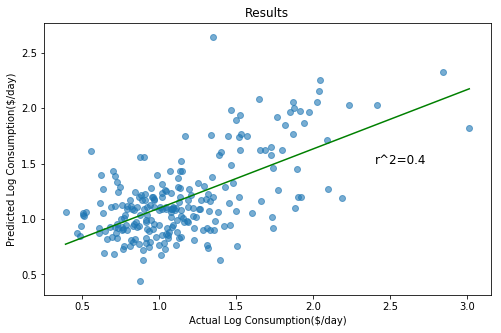

In [39]:
plt.figure(figsize=(8,5))
plt.scatter(valid_y, preds, alpha=0.6)
plt.plot(np.unique(valid_y), np.poly1d(np.polyfit(valid_y, preds, 1))(np.unique(valid_y)), color='g')
plt.text(2.4, 1.5, 'r^2=0.4', size=12)
plt.xlabel('Actual Log Consumption($/day)')
plt.ylabel('Predicted Log Consumption($/day)')
plt.title('Results')